In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.9.1

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/import_pb_to_tensorboard
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/saved_model_cli
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/tensorboard
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/tf_upgrade_v2
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/tflite_convert
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/toco
    /home/juancruz2/Bio2/ProyectoV2/avenv2/bin/toco_from_protos
    /home/juancruz2/Bio2/ProyectoV2/avenv2/lib/python3.10/site-packages/tensorflow-2.16.1.dist-info/*
    /home/juancruz2/Bio2/ProyectoV2/avenv2/lib/python3.10/site-packages/tensorflow/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached Keras_Preprocess

In [4]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [5]:
# Ruta al modelo guardado
model_path = '/home/juancruz2/Bio2/ProyectoV2/efficientnetb3-Eye Disease-95.77.h5' 

# Cargar el modelo
model = tf.keras.models.load_model(model_path)


In [6]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [7]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [8]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [9]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [10]:
data_dir = '/home/juancruz2/Bio2/ProyectoV2/Dataset/dataset/dataset'


try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 3782 validated image filenames belonging to 5 classes.
Found 473 validated image filenames belonging to 5 classes.
Found 473 validated image filenames belonging to 5 classes.


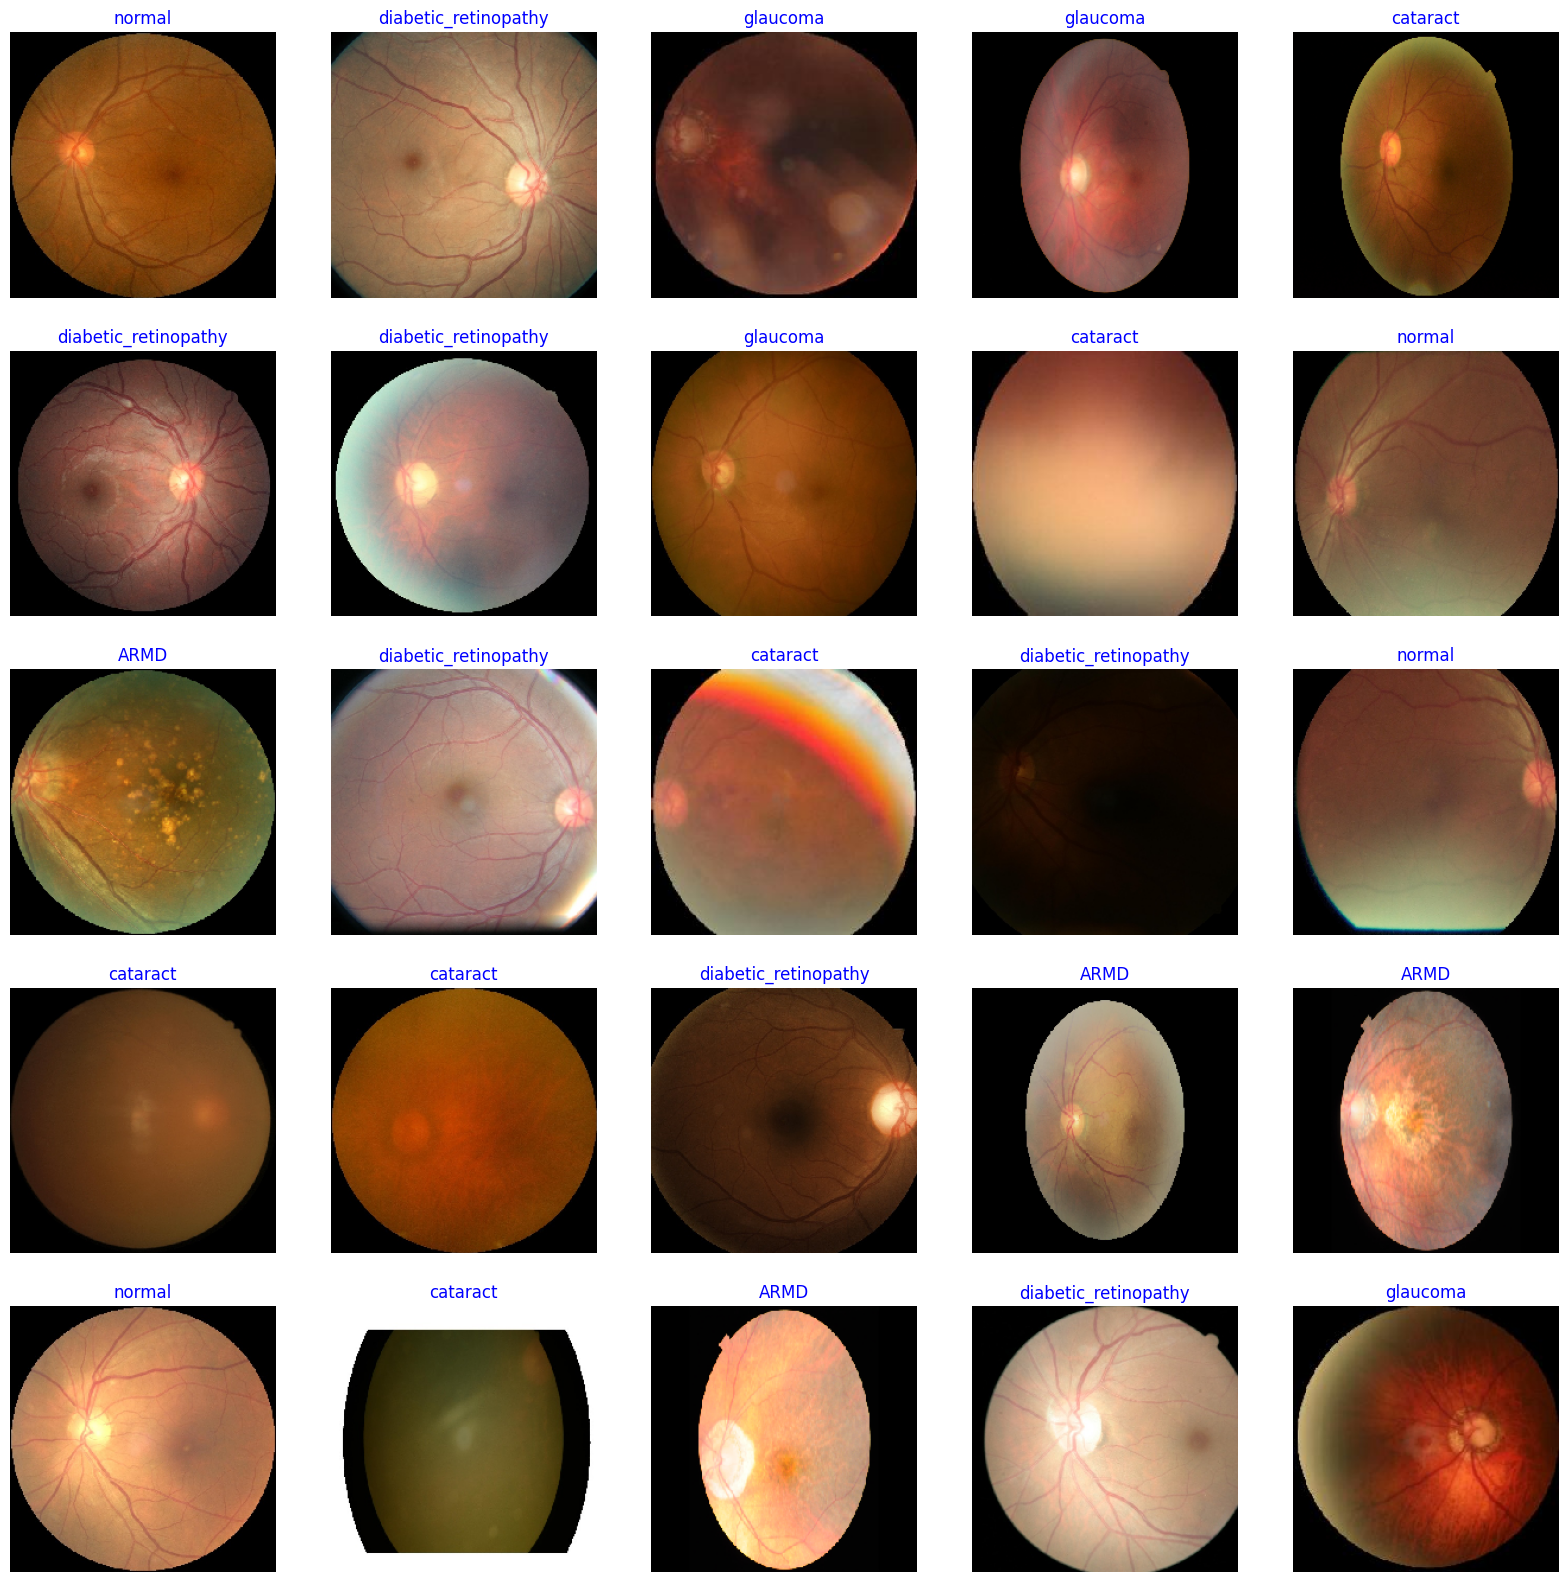

In [11]:
show_images(test_gen)

In [12]:
print(test_df.head())

                                              filepaths                labels
2695  /home/juancruz2/Bio2/ProyectoV2/Dataset/datase...                normal
4158  /home/juancruz2/Bio2/ProyectoV2/Dataset/datase...  diabetic_retinopathy
1400  /home/juancruz2/Bio2/ProyectoV2/Dataset/datase...              glaucoma
1618  /home/juancruz2/Bio2/ProyectoV2/Dataset/datase...              glaucoma
1021  /home/juancruz2/Bio2/ProyectoV2/Dataset/datase...              cataract


In [13]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2024-11-17 21:55:18.619073: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-11-17 21:55:20.515304: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-17 21:55:20.515419: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-17 21:55:20.633534: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

 1/11 [=>............................] - ETA: 44s - loss: 0.2425 - accuracy: 0.9750

2024-11-17 21:55:20.739887: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - 3s 217ms/step - loss: 0.2323 - accuracy: 0.9886


2024-11-17 21:55:27.931560: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-17 21:55:27.931632: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-17 21:55:28.053056: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-17 21:55:28.053138: W tensorflow/core/common_runtime/bfc_allocato

11/11 [==============================] - 4s 240ms/step - loss: 0.2232 - accuracy: 0.9937
Train Loss:  0.24314191937446594
Train Accuracy:  0.9886363744735718
--------------------
Validation Loss:  0.23225893080234528
Validation Accuracy:  0.9886363744735718
--------------------
Test Loss:  0.22316020727157593
Test Accuracy:  0.9936575293540955


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[4 2 3 3 1 2 2 3 1 4 0 2 1 2 4 1 1 2 0 0 4 1 0 2 3 2 3 2 1 4 0 3 4 4 0 2 2
 4 2 3 2 1 0 3 2 2 0 2 3 2 2 1 3 4 2 2 1 4 3 4 0 4 4 4 1 1 0 2 1 1 1 0 2 4
 3 1 3 4 3 1 4 4 2 1 1 1 3 4 2 4 4 3 1 2 3 2 2 3 3 3 1 3 2 2 3 3 3 4 4 3 0
 4 1 1 2 4 4 3 3 1 3 3 2 0 2 3 2 0 4 4 4 0 0 3 4 4 3 1 3 3 1 4 2 1 3 3 4 2
 2 1 4 1 4 4 2 1 3 3 2 2 2 1 4 3 3 2 3 1 3 2 2 2 3 3 3 3 2 1 2 2 4 3 1 3 2
 4 3 4 2 1 1 1 3 3 4 2 2 3 1 2 1 3 2 0 0 1 1 2 4 1 4 1 2 1 0 4 2 4 4 3 3 2
 2 0 4 3 2 0 4 1 0 1 4 0 4 1 2 4 1 1 4 3 2 2 2 1 4 4 4 2 1 3 1 0 1 2 2 4 0
 1 4 4 1 0 1 1 3 0 3 1 2 3 0 4 1 1 2 2 4 0 3 4 2 0 1 2 3 0 0 1 4 3 1 2 2 3
 4 3 2 1 1 3 1 1 1 3 0 3 4 1 4 1 1 4 1 4 3 0 2 0 2 4 1 4 4 3 2 4 4 2 3 2 4
 0 3 3 2 2 1 2 2 3 3 4 4 2 2 3 1 2 0 2 4 2 1 4 1 3 1 1 2 4 0 3 0 0 3 3 4 4
 3 1 0 0 4 0 1 2 3 2 2 0 4 3 1 1 4 2 3 1 3 4 1 1 2 2 4 2 3 4 3 0 0 4 1 2 4
 1 3 1 2 4 4 1 4 2 4 0 2 2 2 3 1 4 3 4 2 0 1 4 1 2 2 4 3 4 3 4 3 1 1 4 0 3
 1 4 4 4 0 2 4 4 3 2 1 1 1 2 1 4 4 1 4 4 4 0 3 2 2 3 3 1 1]


Confusion Matrix, Without Normalization
[[ 51   0   0   0   0]
 [  0 103   0   0   1]
 [  0   0 110   0   0]
 [  0   1   0  99   1]
 [  0   0   0   0 107]]
                      precision    recall  f1-score   support

                ARMD       1.00      1.00      1.00        51
            cataract       0.99      0.99      0.99       104
diabetic_retinopathy       1.00      1.00      1.00       110
            glaucoma       1.00      0.98      0.99       101
              normal       0.98      1.00      0.99       107

            accuracy                           0.99       473
           macro avg       0.99      0.99      0.99       473
        weighted avg       0.99      0.99      0.99       473



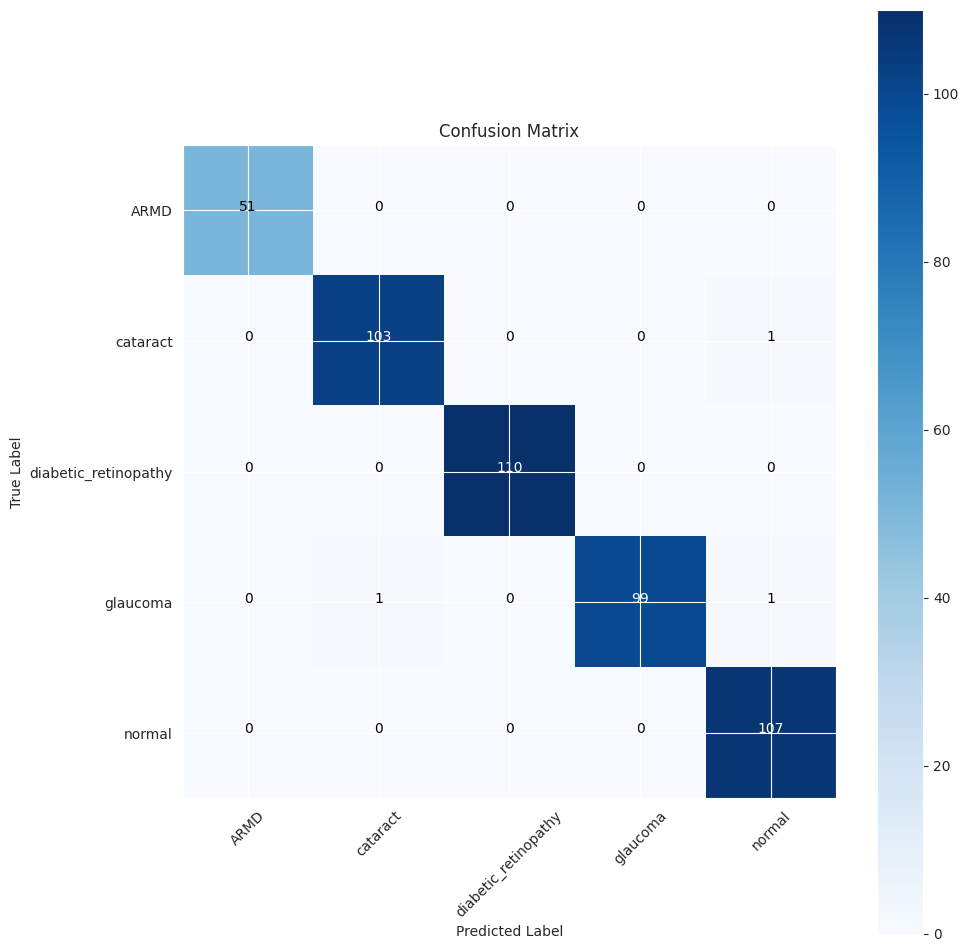

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
print(classes)

['ARMD', 'cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
